---
# 3 REGRESSION APPROACHES (LEAFToolbox-SL2P + ALR)

This notebook contains code blocks to generate predictions based on three different treatment methods, which are as follows:
1. SL2P10 – using only the output from SL2P10_10m
2. LARS + Regression Tree – using feature selection (LARS) and smileCART (GEE function)
3. LARS + Neural Network – as implemented by Hemit in ALR_client_side
---

In [1]:
import ee
import time
import math
import csv
import json
import os
import numpy as np
import pandas as pd
import folium ; from folium import plugins
import matplotlib.pyplot as plt
import scipy ; from scipy import stats
import scipy.io as sio
import sklearn as skl ; from sklearn import linear_model ; from sklearn import preprocessing
import tensorflow as tf
import pickle
from collections import OrderedDict
from PIL import Image

# import custom modules (files must be in same directory as this notebook)
import feature_collections as fc
import image_bands as ib
import wrapper_nets as wn
import ee_functions as ee_func
import ALR_functions as alr

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWjA5b8qscAiDl9heRPt5YguBqDOePkv96gE9O7yO1wXLnKZRUS3tXU



Successfully saved authorization token.


---
# Prelim: Define dictionaries

In [3]:
# -----------------------
# SELECT INPUT PARAMETERS
# -----------------------

# variable name
# one of: 'fAPAR', 'fCOVER', 'LAI'
outputName = 'LAI'

# site selection
# one of: 'Geraldton', 'FoxCreek', 'Kouchibouguac', 'Ottawa',
#         'Wabush', 'QueenCharlotte', 'Attawapiskat', 'Eastmain', 'Charlottetown', 'RedBay', 'EaglePlain', 'Kitchener'
siteSelect = 'Charlottetown'

### Collection options

In [4]:
# ---------------------------------------------------------------------
# set parameters based on user-defined parameters above (do not modify)
# ---------------------------------------------------------------------
outputParams = {
    'fAPAR': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'fCOVER': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'LAI': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 8
    }
}

outputScale = outputParams[outputName]['outputScale']
outputOffset = outputParams[outputName]['outputOffset']
outputMax = outputParams[outputName]['outputMax']
responseBand = 'estimate'+outputName

In [5]:
siteParams = {
    # Geraldton, ON
    'Geraldton': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200811T164849_20200811T165525_T16UEA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-86, 49.5], \
                          [-86, 50], \
                          [-85.5, 50], \
                          [-85.5, 49.5]]]),
        'mapCenter': [-85.75, 49.75]
    },
    # Fox Creek, AB
    'FoxCreek': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20210825T185919_20210825T190431_T11UNA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-117, 54], \
                          [-117, 55], \
                          [-115, 55], \
                          [-115, 54]]]),
        'mapCenter': [-116.8, 54.4]
    },
    # Kouchibouguac, NB
    'Kouchibouguac': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200905T151701_20200905T151829_T20TLS'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-65, 46], \
                          [-65, 47], \
                          [-64, 47], \
                          [-64, 46]]]),
        'mapCenter': [-64.5, 46.5]
    },
    # Ottawa, ON
    'Ottawa': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200801T155911_20200801T160644_T18TVQ'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-75, 45], \
                          [-75, 46], \
                          [-74, 46], \
                          [-74, 45]]]),
        'mapCenter': [-74.5, 45.5]
    },
    # Wabush, NL
    'Wabush': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200815T153911_20200815T154107_T19UFU'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-67.5, 52.3], \
                          [-67.5, 53.2], \
                          [-66.3, 53.2], \
                          [-66.3, 52.3]]]),
        'mapCenter': [-67, 52.8]
    },
    # Queen Charlotte Island, BC
    'QueenCharlotte': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200909T194951_20200909T195633_T08UPE'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-133, 53.2], \
                          [-133, 54], \
                          [-132, 54], \
                          [-132, 53.2]]]),
        'mapCenter': [-132.4, 53.6]
    },
    # Attawapiskat, ON
    'Attawapiskat': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200815T162839_20200815T163731_T17ULU'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-83, 52.3], \
                          [-83, 53.2], \
                          [-82.4, 53.2], \
                          [-82.4, 52.3]]]),
        'mapCenter': [-82.7, 52.7]
    },
    # Eastmain, QC
    'Eastmain': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200723T161829_20200723T162656_T17UPT'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-79.5, 51.4], \
                          [-79.5, 52.3], \
                          [-78, 52.3], \
                          [-78, 51.4]]]),
        'mapCenter': [-78.7, 51.8]
    },
    # Charlottetown, PEI
    'Charlottetown': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200622T151659_20200622T151653_T20TMS'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-63.3, 46.1], \
                          [-63.3, 46.5], \
                          [-62.9, 46.5], \
                          [-62.9, 46.1]]]),
        'mapCenter': [-63.1, 46.3]
    },
    # Red Bay, NL
    'RedBay': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200716T145729_20200716T145730_T21UWT'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-56.6, 51.6], \
                          [-56.6, 52.3], \
                          [-55.6, 52.3], \
                          [-56.6, 51.6]]]),
        'mapCenter': [-56, 52]
    },
    # Eagle Plain, YT
    'EaglePlain': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200731T204019_20200731T204021_T08WMU'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-137, 65.75], \
                          [-137, 66.5], \
                          [-135, 66.5], \
                          [-135, 65.75]]]),
        'mapCenter': [-136.3, 66.5]
    },
    # Kitchener, ON
    'Kitchener': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200615T160911_20200615T161838_T17TNJ'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-81, 43.3], \
                          [-81, 44], \
                          [-79.8, 44], \
                          [-79.8, 43.3]]]),
        'mapCenter': [-80.5, 43.7]
    }
}

mapBounds = siteParams[siteSelect]['mapBounds']
mapCenter = siteParams[siteSelect]['mapCenter']
testImage = siteParams[siteSelect]['testImage']

# other filters
maxCloudcover = 10

# export parameters
exportFolder = siteSelect+'_'+outputName
exportDataType = 'int'
exportScale = 20

In [6]:
COLLECTION_OPTIONS = {
    # Sentinel 2 using 20 m bands:
    'COPERNICUS/S2_SR': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    # Sentinel 2 using 10 m bands:
    'COPERNICUS/S2_SR_10m': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    }
}

VIS_OPTIONS = {
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    }
}

---
# 1 – SL2P/SL2P10

### SL2P Original (create image and export to EE)

In [7]:
# parse the networks
colName = 'COPERNICUS/S2_SR'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [9]:
# filter collection and add ancillary bands

input_collection = ee.ImageCollection(testImage) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

# pre process input imagery and flag invalid inputs
scaled_input_collection = input_collection.map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                          .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

# apply networks to produce mapped parameters
estimateSL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

# scale and offset mapped parameter bands
estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))
uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))

# produce final export collection
export_collection = input_collection.combine(estimateSL2P).combine(uncertaintySL2P)
    
#image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])
image_output_names = ([name+"_"+siteSelect+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

In [10]:
# export tasks to Earth Engine
# export_task = ee_func.export_collection_to_gee(collection=export_collection,
#                                                num_images=1,
#                                                image_names=[siteSelect+'_'+outputName+'_SL2P'],
#                                                scale=10,
#                                                asset_folder='users/kateharvey/SL2P_images',
#                                                data_type=exportDataType,
#                                                max_pixels=1e13)

#export tasks to gee asset
export_task = ee_func.export_collection_to_gee(collection = export_collection,
                                          num_images = 1,
                                          image_names = image_output_names,
                                          asset_folder='users/ganghong/ALR',
                                          scale = 10,
                                          data_type = exportDataType,
                                          max_pixels = 1e13)

### SL2P10 (for comparison)

In [11]:
# parse the networks
colName = 'COPERNICUS/S2_SR_10m'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [12]:
# performs same procedure as above, using SL2P10 network
# applies algorithm to 10 m bands ; generates a 10 m map

# filter collection and add ancillary bands
input_collection_10m = ee.ImageCollection(testImage) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

# pre process input imagery and flag invalid inputs
scaled_input_collection_10m = input_collection_10m.map(lambda image: ib.s2MaskLand(image)) \
                                                  .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                                  .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

# apply networks to produce mapped parameters
estimateSL2P_10m = scaled_input_collection_10m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P_10m = scaled_input_collection_10m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

# scale and offset mapped parameter bands
estimateSL2P_10m = estimateSL2P_10m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                             .multiply(ee.Image.constant(outputScale)) \
                                                             .add(ee.Image.constant(outputOffset)), overwrite=True))
uncertaintySL2P_10m = uncertaintySL2P_10m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                   .multiply(ee.Image.constant(outputScale)) \
                                                                   .add(ee.Image.constant(outputOffset)), overwrite=True))


# produce final export collection
export_collection_10m = input_collection_10m.combine(estimateSL2P_10m).combine(uncertaintySL2P_10m)

#image_output_names_10m = ([name+"_"+outputName+"_10m" for name in export_collection_10m.toList(export_collection_10m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
image_output_names_10m = ([name+"_"+siteSelect+"_"+outputName+"_10m" for name in export_collection_10m.toList(export_collection_10m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection_10m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

In [13]:
# export tasks to Earth Engine
# export_task_10m = ee_func.export_collection_to_gee(collection=export_collection_10m,
#                                                    num_images=1,
#                                                    image_names=[siteSelect+'_'+outputName+'_SL2P10'],
#                                                    scale=10,
#                                                    asset_folder='users/kateharvey/SL2P10_images',
#                                                    data_type=exportDataType,
#                                                    max_pixels=1e13)

export_task = ee_func.export_collection_to_gee(collection = export_collection_10m,
                                          num_images = 1,
                                          image_names = image_output_names_10m,
                                          asset_folder='users/ganghong/ALR',
                                          scale = 10,
                                          data_type = exportDataType,
                                          max_pixels = 1e13)

# 2 – Active Learning Regularization (LARS Feature Selection)

Note: the responseBand from the above step doesn't have a geometry associated with it (only happens after being uploaded to GEE) so the image will have to be defined from existing GEE asset for the remaining steps even though the same image was created as inputImage (should be identical except for geometry)

In [14]:
# order of bands from SL2P output:
# 00-11: 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
# 12-19: 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 
# 20-26: 'QA10', 'QA20', 'QA60', 'date', 'cosVZA', 'cosSZA', 'cosRAA', 
# 27-32: 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'

# define 10m band input image ; name bands of inputImage and scale response band
#inputImage = ee.Image('users/kateharvey/SL2P_images/'+siteSelect+'_'+outputName+'_SL2P').select(1,2,3,7,22,23,27,28,29,30,31,32)
inputImage = ee.Image('users/ganghong/ALR/'+image_output_names_10m[0]).select(1,2,3,7,22,23,27,28,29,30,31,32)
inputImage_bands = ee.List(['B2', 'B3', 'B4', 'B8', 'QA60', 'date', 'estimate'+outputName, 'partition', 'networkID', 'error'+outputName, 'partition_1', 'networkID_1'])
inputImage = inputImage.rename(inputImage_bands)

In [15]:
# Only include VIs that use B2, B3, B4, B8 to create a 10 m product
input_VI_definition = ee.List([# "RAW_B2  = b('B2')",
                             # "RAW_B3  = b('B3')",
                             # "RAW_B4  = b('B4')",
                             # "RAW_B8  = b('B8')",
                               "GI      = b('B3')/b('B4')",
                             # "RVI3    = b('B4')/b('B6')",
                             # "SR3     = b('B5')/b('B4')",
                             # "GM1     = b('B6')/b('B3')",
                             # "GM2     = b('B6')/b('B5')",
                             # "SR2     = b('B7')/b('B3')",
                             # "PSSR    = b('B7')/b('B4')",
                               "SGI     = b('B8')/b('B4')",
                             # "MSI     = b('B11')/b('B7')",
                             # "II      = b('B11')/b('B12')",
                               "GVI     = (b('B8')/b('B3'))-1",
                             # "PSRI    = (b('B4')-b('B3'))/b('B6')",
                               "NDVI3   = ((b('B8')-b('B4'))/(b('B8')))+b('B4')",
                             # "SR5     = 1/b('B5')",
                             # "SR6     = b('B4')/(b('B3')*b('B5'))",
                             # "SR7     = b('B8')/(b('B3')*b('B5'))",
                             # "IPVI    = b('B7')/(b('B7')+b('B4'))",
                             # "ARI     = (1/b('B3'))-(1/b('B5'))",
                             # "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                               "NDVI    = (b('B8')-b('B4'))/(b('B8')+b('B4'))",
                               "GNDVI   = (b('B8')-b('B3'))/(b('B8')+b('B3'))",
                             # "NDWI    = (b('B8')-b('B11'))/(b('B8')+b('B11'))",
                             # "NDREVI  = (b('B8')-b('B5'))/(b('B8')+b('B5'))",
                               "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                             # "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                             # "NDI2    = (b('B8')-b('B5'))/(b('B8')-b('B4'))",
                             # "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                             # "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                             # "NMDI    = (b('B8')-(b('B11')-b('B12')))/(b('B8')+(b('B11')-b('B12')))",
                             # "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                             # "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                             # "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                             # "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                               "EVI     = 2.5*((b('B8')-b('B4'))/(b('B8')+6*b('B4')-7.5*b('B3')+1))",
                               "EVI2    = 2.5*((b('B8')-b('B4'))/(b('B8')+2.4*b('B4')+1))",
                               "RDVI    = (b('B8')-b('B4'))/((b('B8')+b('B4'))**0.5)",
                               "MSR     = ((b('B8')/b('B4'))-1)/((b('B8')/b('B4'))**0.5+1)",
                             # "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                               "MSAVI2  = 0.5*(2*b('B8')+1-((2*b('B8')+1)**2-8*(b('B8')-b('B4')))**0.5)",
                             # "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                             # "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                             # "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                               "NLI     = ((b('B8')**2)-b('B4'))/((b('B8')**2)+b('B4'))"])

# names of bands to pass to ALR method (excluding metadata and other non-spectral bands)
input_bandNames = ['B2', 'B3', 'B4', 'B8', 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI']

In [16]:
# format image and generate list of selected features
inputImage = alr.format_image(inputImage, inputImage_bands, responseBand, input_VI_definition)

In [17]:
# prepares the image to be ingested by the LARS algorithm
# returns an image with the response band centred to a mean 0, and the other bands in the image standardized
# to a mean 0 and standard deviation 1
scaledImage = alr.scale_image(inputImage, responseBand)

In [18]:
# apply ALR to the image and obtain the features selected for the model
# parameters: ee_LARS(inputImage, bandNames, responseBand, numFeatures, numSamples)
select_features = alr.ee_LARS(scaledImage, input_bandNames, responseBand, 5, 10000)

selected features:  ['GVI', 'RDVI', 'MSR', 'B8', 'NDGI']


### Export VI Image

In [19]:
# export formatted image to google drive (with added VI bands)
# this will be used in the next section to train the regression tree
export = ee.ImageCollection(inputImage)

export_task = ee_func.export_collection_to_gee(collection=export,
                                                 num_images=1,
                                                 image_names=[siteSelect+'_'+outputName+'_VI'],
                                               #  asset_folder='users/kateharvey/vi_images',  # replace with EE destination folder
                                                asset_folder='users/ganghong/ALR',
                                                 scale=10,
                                                 data_type=exportDataType,
                                                 max_pixels=1e13)

---
# 2a – Regression Tree (Random Forest and CART)

### Train and Apply Regression Tree to Image

In [20]:
# DEFINE IMAGE & FORMAT BANDS
#unclassified = ee.Image('users/kateharvey/vi_images/'+siteSelect+'_'+outputName+'_VI')
unclassified = ee.Image('users/ganghong/ALR/'+siteSelect+'_'+outputName+'_VI')
bands = ee.List([responseBand, 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI',
                 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI', 'B2', 'B3', 'B4', 'B8',
                 'QA60', 'date', 'partition', 'networkID', 'error'+outputName, 'partition_1', 'networkID_1'])
unclassified = unclassified.rename(bands)

# prediction bands (equivalent to select_features, with responseBand)
bands = select_features
input_bands = select_features.add(responseBand)

In [21]:
# GET TRAINING DATASET
# Feature Vector (table) used to train regression model (select only prediction bands)
training_data = ee.FeatureCollection(unclassified.sample(numPixels=1000, seed=1).select(input_bands))

In [22]:
# CREATE CLASSIFIERS

# implement regression tree with Random Forest algorithm
# optional parameters for smileRandomForest(): numberOfTrees, variablesPerSplit, minLeafPopulation, bagFraction, maxNodes, seed
rf_classifier = ee.Classifier.smileRandomForest(100).setOutputMode('REGRESSION').train(features=training_data,
                                                                                       classProperty=responseBand,
                                                                                       inputProperties=input_bands)

# implement regression tree with CART (Classification and Regression Tree) algorithm
# optional parameters for smileCart(): maxNodes, minLeafPopulation
cart_classifier = ee.Classifier.smileCart().setOutputMode('REGRESSION').train(features=training_data,
                                                                              classProperty=responseBand,
                                                                              inputProperties=input_bands)

In [23]:
# CLASSIFY IMAGE
rf_classified = unclassified.select(bands).classify(rf_classifier, 'rf_'+responseBand).clip(mapBounds)
cart_classified = unclassified.select(bands).classify(cart_classifier, 'cart_'+responseBand).clip(mapBounds)

In [24]:
# CHECK RESULTS (CROSS-VALIDATION)
joined_image = unclassified.select(responseBand).addBands(rf_classified.select('rf_'+responseBand)).addBands(cart_classified.select('cart_'+responseBand))

# using same random seed as training_data, get 2000 samples and discard the first 1000, leaving 1000 different samples for cross-validation
# this sampling method ensures no overlap between training and testing datasets
joined_samples = ee.FeatureCollection(joined_image.sample(numPixels=2000, seed=1).toList(2000, 1000))

### Export Feature Collection (for scatter plot comparison in next section)

In [25]:
export_csv = ee.batch.Export.table.toDrive(collection=joined_samples,
                                           description=siteSelect+'_'+outputName+'_regression_tree',
                                           fileFormat='CSV')

# Start the export task
export_csv.start()

In [26]:
# Wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(export_csv.id)[0]["state"]
print(prev_task_status)
while export_csv.active():
    task_status = ee.data.getTaskStatus(export_csv.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(export_csv.id)[0]["state"])

READY
RUNNING
COMPLETED


### Visualize and Compare Predictions:

In [27]:
# Read the CSV file into dataframe
data = pd.read_csv('./gdrive/'+siteSelect+'_'+outputName+'_regression_tree.csv')

# remove rows that have a value of 0 for the responseBand
data = data[data[responseBand] != 0]


# Get column data (for plots [0,1] and [1,1])
rf = data['rf_'+responseBand]/1000    # divide by 1000 to get properly scaled values for the variable
cart = data['cart_'+responseBand]/1000
actual = data[responseBand]/1000

# Obtain point density to display as a scatterplot (KDE)
xy_rf = np.vstack([actual, rf])
z_rf = scipy.stats.gaussian_kde(xy_rf)(xy_rf)

xy_cart = np.vstack([actual, cart])
z_cart = scipy.stats.gaussian_kde(xy_cart)(xy_cart)


# Sort by responseBand in ascending order (for plots [0,0] and [1,0] below)
data_sorted = data.sort_values(responseBand, axis=0).reset_index(drop=True)
rf_sorted = data_sorted['rf_'+responseBand]/1000
cart_sorted = data_sorted['cart_'+responseBand]/1000
actual_sorted = data_sorted[responseBand]/1000
index_sorted = data_sorted.index

# Obtain point density for sorted values
xy_rf_sorted = np.vstack([actual_sorted, rf_sorted])
z_rf_sorted = scipy.stats.gaussian_kde(xy_rf_sorted)(xy_rf_sorted)

xy_cart_sorted = np.vstack([actual_sorted, cart_sorted])
z_cart_sorted = scipy.stats.gaussian_kde(xy_cart_sorted)(xy_cart_sorted)

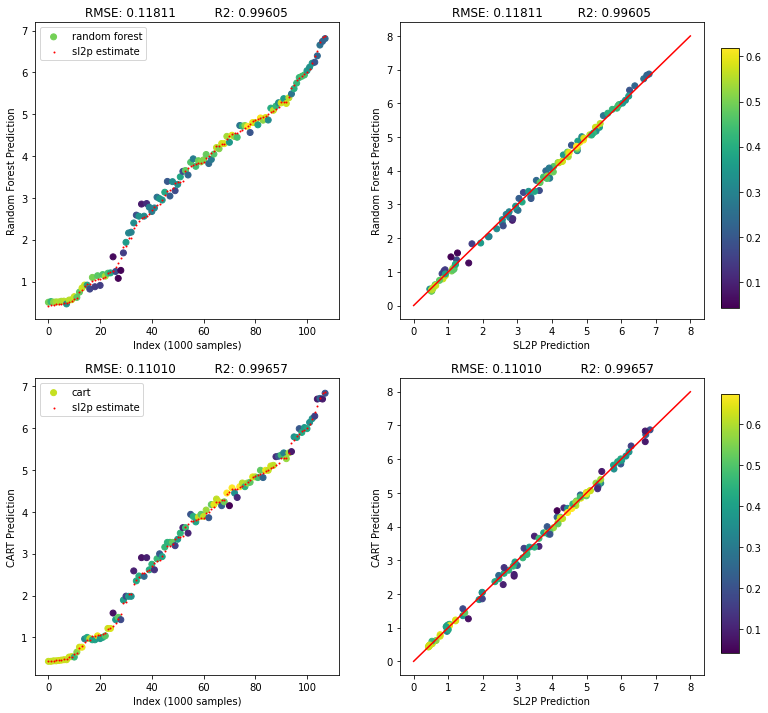

In [28]:
# PLOT & COMPARE PREDICTIONS FROM BOTH REGRESSION TREES
fig, ax = plt.subplots(2, 2, figsize=(12,12))
xy = np.linspace(0, outputMax, 100)

# ax[0,0]
fig1 = ax[0,0].scatter(index_sorted, rf_sorted, c=z_rf_sorted, label='random forest')
ax[0,0].scatter(index_sorted, actual_sorted, c='r', s=1, label='sl2p estimate')
rf_rmse_sorted = skl.metrics.mean_squared_error(actual_sorted, rf_sorted, squared=False)
rf_r2_sorted = skl.metrics.r2_score(actual_sorted, rf_sorted)

ax[0,0].title.set_text('RMSE: {rmse:.5f}          R2: {r2:.5f}'.format(rmse=rf_rmse_sorted, r2=rf_r2_sorted))
ax[0,0].set_xlabel('Index (1000 samples)')
ax[0,0].set_ylabel('Random Forest Prediction')
ax[0,0].legend()


# ax[0,1]
ax[0,1].plot(xy, xy, c='r')
fig2 = ax[0,1].scatter(rf, actual, c=z_rf)
rf_rmse = skl.metrics.mean_squared_error(actual, rf, squared=False)
rf_r2 = skl.metrics.r2_score(actual, rf)

ax[0,1].title.set_text('RMSE: {rmse:.5f}         R2: {r2:.5f}'.format(rmse=rf_rmse, r2=rf_r2))
ax[0,1].set_xlabel('SL2P Prediction')
ax[0,1].set_ylabel('Random Forest Prediction')

fig.subplots_adjust(right=0.9)
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.3])
fig.colorbar(fig2, cax=cbar_ax1)


# ax[1,0]
fig3 = ax[1,0].scatter(index_sorted, cart_sorted, c=z_cart_sorted, label='cart')
ax[1,0].scatter(index_sorted, actual_sorted, c='r', s=1, label='sl2p estimate')
cart_rmse_sorted = skl.metrics.mean_squared_error(actual_sorted, cart_sorted, squared=False)
cart_r2_sorted = skl.metrics.r2_score(actual_sorted, cart_sorted)

ax[1,0].title.set_text('RMSE: {rmse:.5f}          R2: {r2:.5f}'.format(rmse=cart_rmse_sorted, r2=cart_r2_sorted))
ax[1,0].set_xlabel('Index (1000 samples)')
ax[1,0].set_ylabel('CART Prediction')
ax[1,0].legend()


# ax[1,1]
ax[1,1].plot(xy, xy, c='r')
fig4 = ax[1,1].scatter(cart, actual, c=z_cart)
cart_rmse = skl.metrics.mean_squared_error(actual, cart, squared=False)
cart_r2 = skl.metrics.r2_score(actual, cart)
ax[1,1].title.set_text('RMSE: {rmse:.5f}          R2: {r2:.5f}'.format(rmse=cart_rmse, r2=cart_r2))
ax[1,1].set_xlabel('SL2P Prediction')
ax[1,1].set_ylabel('CART Prediction')

fig.subplots_adjust(right=0.9)
cbar_ax3 = fig.add_axes([0.92, 0.15, 0.02, 0.3])
fig.colorbar(fig4, cax=cbar_ax3)

# save plot as .png
fig.savefig('./plots/trees/'+siteSelect+'_'+outputName+'_rf_cart_comparison.png')

### Export Random Forest image to EE

In [29]:
# Display map:
# m = folium.Map(location=mapCenter, zoom_start=12, height=400)

vis_params = {
    'min': 0,
    'max': outputScale*outputMax}

rf_map = ee.Image(ee_func.displayImage(rf_classified, vis_params['min'], vis_params['max'], mapBounds)).clip(mapBounds)
# ee_func.displayImage(cart_classified, vis_params['min'], vis_params['max'], mapBounds)
# sl2p_layer = m.add_ee_layer(unclassified, vis_params, 'Image')

In [31]:
# Export directly to EE:
# export_task = ee_func.export_collection_to_gee(collection=rf_classified,
#                                                num_images=1,
#                                                image_names=[siteSelect+'_'+outputName+'_random_forest_10m'],
#                                                scale=10,
#                                                asset_folder='users/kateharvey/regression_images',
#                                                data_type=exportDataType,
#                                                max_pixels=1e13)


export_task = ee_func.export_collection_to_gee(collection=rf_classified,
                                                 num_images=1,
                                                 image_names=[siteSelect+'_'+outputName+'_rf_10m'],
                                                 scale=10,
                                                 asset_folder='users/ganghong/ALR',
                                                 data_type=exportDataType,
                                                 max_pixels=1e13)

---
# 2b – NNET (Tensorflow)

### Exports

In [32]:
# scale image responseBand for export (was multiplied by 1000 for previous steps, so rescale before proceeding)
inputImage = inputImage.addBands(inputImage.select(responseBand).divide(1000), overwrite=True)
# inputImage.sample(numPixels=100).getInfo()

In [33]:
# Create the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
trimmedCollection = alr.trim_data(image=inputImage.updateMask(inputImage.select(responseBand).gt(0)),
                                  selected_features=select_features,
                                  response_band=responseBand,
                                  num_samples=10000,
                                  num_partitions=10)

exportData = ee.batch.Export.table.toDrive(collection=trimmedCollection,
                                           description=siteSelect+'_'+outputName+'_nnet_10m',
                                           fileFormat="CSV")

# Start the export data task
exportData.start()

In [34]:
# Wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
print(prev_task_status)
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

READY
RUNNING
COMPLETED


Note: This will create a .csv in the user's google drive folder that must be put into the 'gdrive' folder inside this directory so it can be used in the next section.

### Read data and make nets

In [35]:
# Read the CSV file into dataframes
trimmed_data = pd.read_csv('./gdrive/'+siteSelect+'_'+outputName+'_nnet_10m.csv')
X = trimmed_data.drop(labels=[responseBand, 'system:index', '.geo'], axis=1)
y = trimmed_data[responseBand]

# Preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pd.DataFrame(skl.preprocessing.scale(X))

In [36]:
# Use Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
model = alr.make_nets(X, y)

Epoch 1/100
126/126 [==============================] - 1s 2ms/step - loss: 10.5344 - mse: 10.5344 - mae: 2.9501
Epoch 2/100
126/126 [==============================] - 0s 1ms/step - loss: 6.6503 - mse: 6.6503 - mae: 2.1443
Epoch 3/100
126/126 [==============================] - 0s 2ms/step - loss: 4.6051 - mse: 4.6051 - mae: 1.6636
Epoch 4/100
126/126 [==============================] - 0s 1ms/step - loss: 3.3772 - mse: 3.3772 - mae: 1.3733
Epoch 5/100
126/126 [==============================] - 0s 1ms/step - loss: 2.5554 - mse: 2.5554 - mae: 1.1544
Epoch 6/100
126/126 [==============================] - 0s 1ms/step - loss: 1.9778 - mse: 1.9778 - mae: 0.9814
Epoch 7/100
126/126 [==============================] - 0s 2ms/step - loss: 1.5625 - mse: 1.5625 - mae: 0.8488
Epoch 8/100
126/126 [==============================] - 0s 2ms/step - loss: 1.2607 - mse: 1.2607 - mae: 0.7448
Epoch 9/100
126/126 [==============================] - 0s 2ms/step - loss: 1.0401 - mse: 1.0401 - mae: 0.6676
Epoch 10

In [37]:
# Predict our input data to evaluate the performance (for now)
predictions = pd.Series(model.predict(X.to_numpy()).flatten())

In [38]:
# Prepare data to display as a scatterplot
xy_tf = np.vstack([y, predictions])
z_tf = scipy.stats.gaussian_kde(xy_tf)(xy_tf)

idx_tf = z_tf.argsort()
x_tf = y[idx_tf]
y_tf = predictions[idx_tf]
z_tf = z_tf[idx_tf]

rmse_tf = skl.metrics.mean_squared_error(x_tf, y_tf, squared=False)

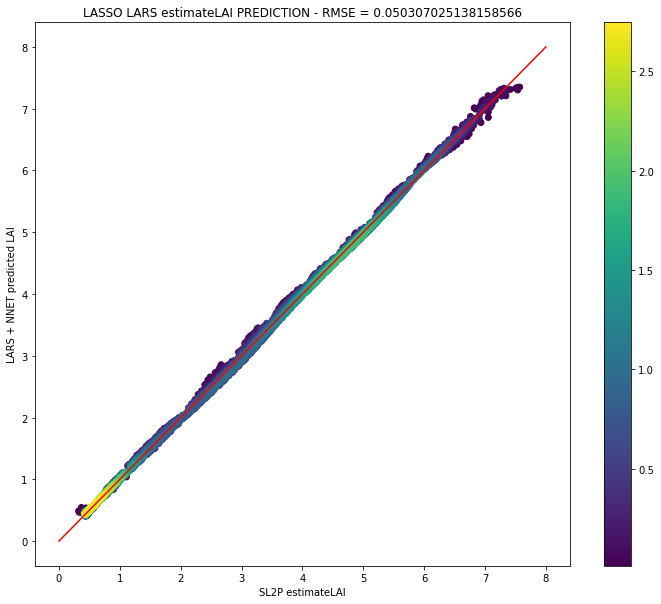

In [39]:
a_tf = np.linspace(0, outputMax, 1000)
fig, ax = plt.subplots(1, 1, figsize=(12,10))

fig1 = ax.scatter(x_tf, y_tf, c=z_tf)
ax.plot(a_tf, a_tf, c='r')
ax.set_xlabel('SL2P {}'.format(responseBand))
ax.set_ylabel('LARS + NNET predicted {}'.format(outputName))
plt.colorbar(mappable=fig1, ax=ax)

ax.title.set_text('LASSO LARS {} PREDICTION - RMSE = {}'.format(responseBand, rmse_tf))

# save plot as .png
fig.savefig('./plots/lars/'+siteSelect+'_'+outputName+'_lars.png')

In [40]:
model.get_weights()

[array([[-0.53187543, -0.57906747,  0.00474063,  0.7548743 ,  0.22432068],
        [-0.4499539 , -1.0666883 , -0.179235  ,  0.5671045 , -0.29443613],
        [-0.19184114, -0.04207738, -0.3632074 ,  0.6113836 , -0.26619735],
        [ 0.35183856, -0.19040278,  0.0758069 , -0.26485312, -0.3115348 ],
        [ 0.25452211,  0.29692736,  0.3651697 ,  0.47474828, -0.27861553]],
       dtype=float32),
 array([ 0.23230506, -0.19734082, -1.4960467 , -1.131273  , -0.20307955],
       dtype=float32),
 array([[-0.14009666, -0.3197638 , -0.04143398, -0.06998035],
        [ 0.59889585, -0.2251057 ,  1.0370228 , -0.17031938],
        [-1.8851157 ,  1.3418466 ,  0.6837763 , -0.66321987],
        [-0.26189023,  0.4553057 ,  0.56565684, -0.5998559 ],
        [ 0.42829856,  0.6042482 ,  0.38297737,  0.382731  ]],
       dtype=float32),
 array([ 0.162813  , -0.48245996, -0.3585668 , -0.2027837 ], dtype=float32),
 array([[-1.3735455 ,  1.0928043 , -0.12742254],
        [ 0.7213674 ,  1.0669506 , -1.218021

In [41]:
elu = np.vectorize(alr.elu)
softplus = np.vectorize(alr.softplus)
softsign = np.vectorize(alr.softsign)
relu = np.vectorize(alr.relu)
tanh = np.vectorize(alr.tanh)
sigmoid = np.vectorize(alr.sigmoid)

In [46]:
#row = 4802
#row = 3802
row=X.shape[0]-1
#print (row)
inputs = X.iloc[row, :].to_numpy()
print(model.predict(inputs.reshape((-1,5)))[0][0])
print(alr.apply_nnet(inputs, model)[0])

4019
6.5192227
6.519222609929841


In [47]:
# Writing the neural network to a CSV file to be uploaded to the server side on Google Earth Engine
export_data = alr.export_nnet(model, X)
with open(siteSelect+'_'+outputName+'_nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)